# 1. Normal Option pricing

期权定价

我们想知道下面的一只期权的价格：

当前价 spot : 2.45
行权价 strike: 2.50
到期期限 maturity : 0.25
无风险利率 r : 0.05
波动率 vol : 0.25
关于这样的简单欧式期权的定价，有经典的Black - Scholes [1] 公式：


其中S为标的价格，K为执行价格，r为无风险利率，τ=T−t为剩余到期时间。 N(x)为标准正态分布的累积概率密度函数。Call(S,K,r,τ,σ)为看涨期权的价格。


spot = 2.45
strike = 2.50
maturity = 0.25
r = 0.05
vol = 0.25

In [4]:
spot = 2.45
strike = 2.50
maturity = 0.25
r = 0.05
vol = 0.25

In [6]:
# 基于Black - Scholes 公式的期权定价公式
from math import log, sqrt, exp
from scipy.stats import norm

def call_option_pricer(spot, strike, maturity, r, vol):

    d1 = (log(spot/strike) + (r + 0.5 * vol *vol) * maturity) / vol / sqrt(maturity)
    d2 = d1 - vol * sqrt(maturity)

    price = spot * norm.cdf(d1) - strike * exp(-r*maturity) * norm.cdf(d2)
    return price

In [8]:
print('期权价格 : %.4f' % call_option_pricer(spot, strike, maturity, r, vol))

期权价格 : 0.1133


# 2. Batch handle data and calculation time

### 2.1 Loop

In [32]:
import time
import numpy as np

##range(start, stop, step) 
##portfolioSize: 1,501,1001,1501,2001,2501

portfolioSize = range(1,10000,500)
timeSpent=[]

for size in portfolioSize:
    now = time.time()
    strikes = np.linspace(2.0,3.0,size)
    ## get diff strikes b/w 2 -- 3 of above portfolioSize
    ## price for options in the diff list of strikes (1 stirke, 500 strike, 1000 strike)
    for i in range(size):
        res = call_option_pricer(spot, strikes[i], maturity, r, vol)
    timeSpent.append(time.time() - now)

Text(0.5, 0, 'PortfolioSize')

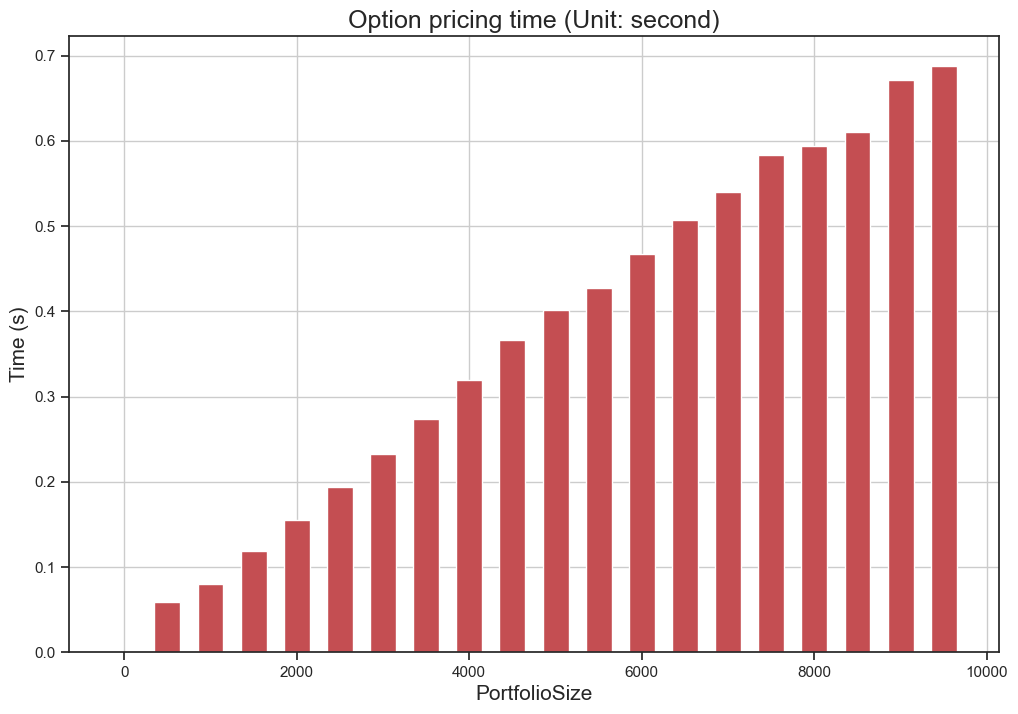

In [38]:
from matplotlib import pylab
import seaborn as sns
#font.set_size(15)
sns.set(style="ticks")
pylab.figure(figsize = (12,8))
pylab.bar(portfolioSize, timeSpent, color = 'r', width =300)
pylab.grid(True)
pylab.title(u'Option pricing time (Unit: second)', fontsize = 18)
pylab.ylabel(u'Time (s)', fontsize = 15)
pylab.xlabel(u'PortfolioSize', fontsize = 15)


### 2.2 Numpy array

In [42]:
sample = np.linspace(1.0,100.0,5)
np.exp(sample)

array([2.71828183e+00, 1.52434373e+11, 8.54813429e+21, 4.79357761e+32,
       2.68811714e+43])

In [43]:
# 使用numpy的向量函数重写Black - Scholes公式
def call_option_pricer_nunmpy(spot, strike, maturity, r, vol):

    d1 = (np.log(spot/strike) + (r + 0.5 * vol *vol) * maturity) / vol / np.sqrt(maturity)
    d2 = d1 - vol * np.sqrt(maturity)

    price = spot * norm.cdf(d1) - strike * np.exp(-r*maturity) * norm.cdf(d2)
    return price


In [44]:
timeSpentNumpy = []
for size in portfolioSize:
    now = time.time()
    strikes = np.linspace(2.0,3.0, size)
    res = call_option_pricer_nunmpy(spot, strikes, maturity, r, vol)
    timeSpentNumpy.append(time.time() - now)

Text(0.5, 0, 'PortfolioSize')

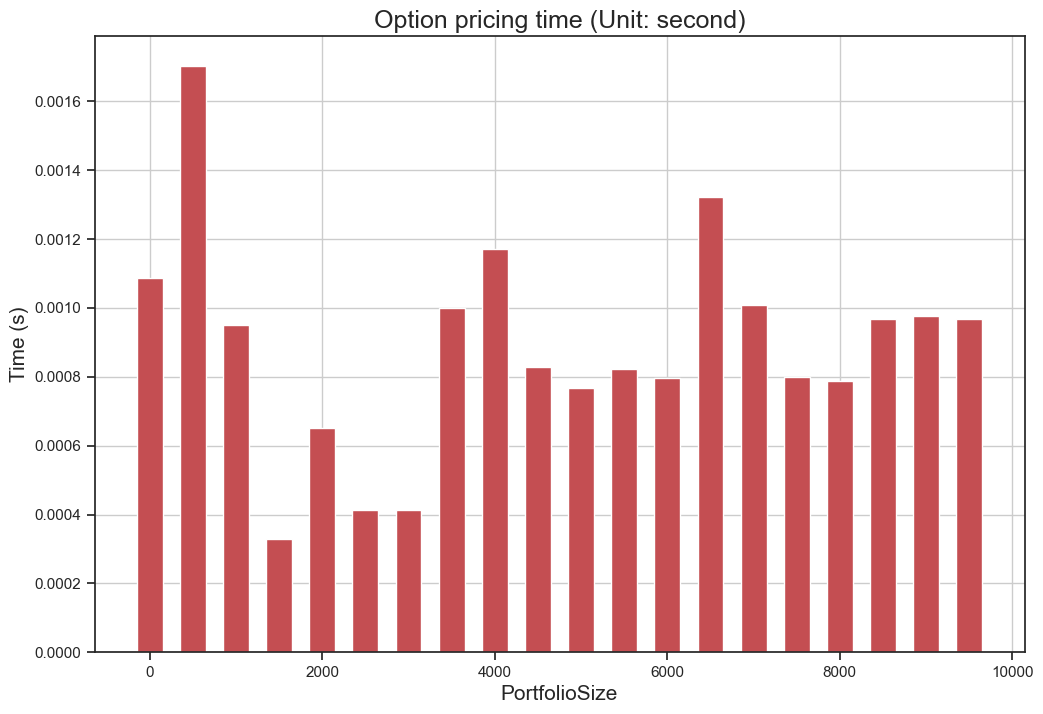

In [45]:
pylab.figure(figsize = (12,8))
pylab.bar(portfolioSize, timeSpentNumpy, color = 'r', width = 300)
pylab.grid(True)
pylab.title(u'Option pricing time (Unit: second)', fontsize = 18)
pylab.ylabel(u'Time (s)', fontsize = 15)
pylab.xlabel(u'PortfolioSize', fontsize = 15)

Text(0.5, 0, 'PortfolioSize')

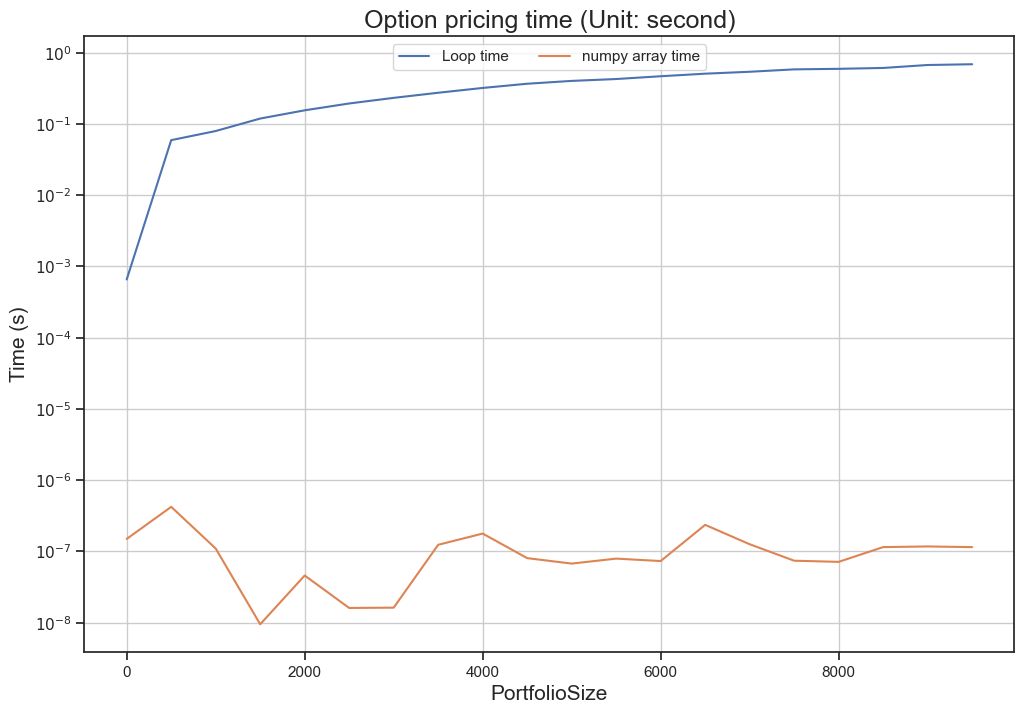

In [47]:
fig = pylab.figure(figsize = (12,8))
ax = fig.gca()
pylab.plot(portfolioSize, np.log10(timeSpent), portfolioSize, np.log(timeSpentNumpy))
pylab.grid(True)
from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '$10^{%.0f}$' % (x)
formatter = FuncFormatter(millions)
ax.yaxis.set_major_formatter(formatter)
pylab.title(u'Option pricing time (Unit: second)', fontsize = 18)
pylab.legend([u'Loop time', u'numpy array time'], loc = 'upper center', ncol = 2)
pylab.ylabel(u'Time (s)', fontsize = 15)
pylab.xlabel(u'PortfolioSize', fontsize = 15)

# 3 Scipy Pseudo Calculation

In [52]:
import scipy
np.random.randn(10)

array([-0.31343621, -1.05113238, -1.94432043, -0.04720414, -0.47742509,
       -0.30504438,  0.83331759, -0.86508327, -0.53375165,  0.62648381])

Mean：0.3311
Std Dev：1.1786


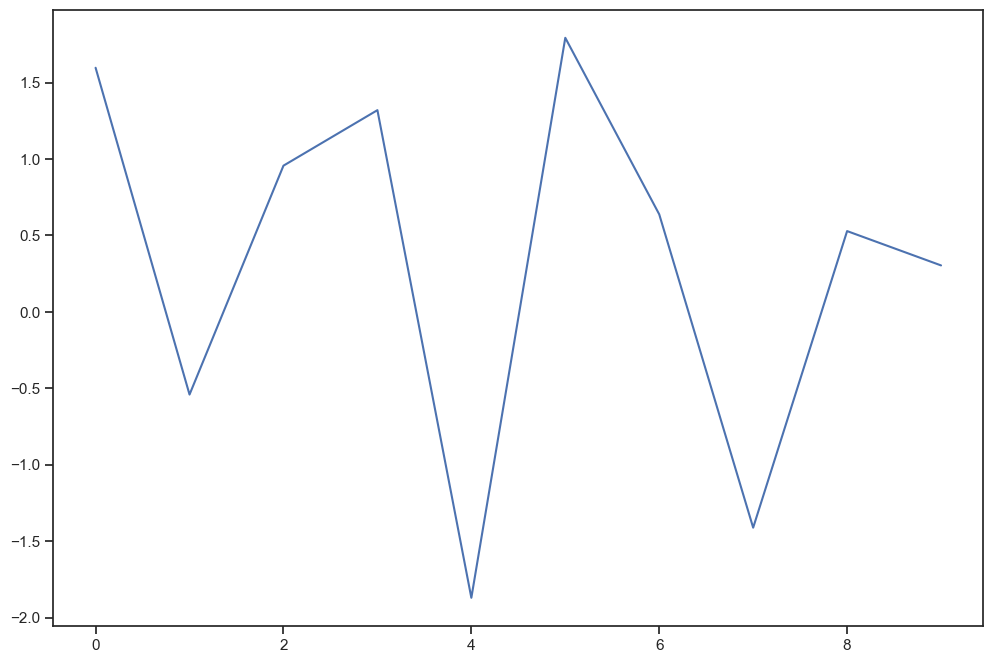

In [54]:
pylab.figure(figsize = (12,8))
randomSeries = np.random.randn(10)
pylab.plot(randomSeries)
print(u'Mean：%.4f' % randomSeries.mean())
print(u'Std Dev：%.4f' % randomSeries.std())

In [57]:
# Option pricing with Monte Carlo
def call_option_pricer_monte_carlo(spot, strike, maturity, r, vol, numOfPath = 5000):
    randomSeries = np.random.randn(numOfPath)
    s_t = spot * np.exp((r - 0.5 * vol * vol) * maturity + randomSeries * vol * sqrt(maturity))
    sumValue = np.maximum(s_t - strike, 0.0).sum()
    price = exp(-r*maturity) * sumValue / numOfPath
    return price

In [58]:
print('Option Price (Monte Carlo): %.4f' % call_option_pricer_monte_carlo(spot, strike, maturity, r, vol))

Option Price (Monte Carlo): 0.1137


In [59]:
pathScenario = range(1000, 50000, 1000)
numberOfTrials = 100

confidenceIntervalUpper = []
confidenceIntervalLower = []
means = []

for scenario in pathScenario:
    res = np.zeros(numberOfTrials)
    for i in range(numberOfTrials):
        res[i] = call_option_pricer_monte_carlo(spot, strike, maturity, r, vol, numOfPath = scenario)
    means.append(res.mean())
    confidenceIntervalUpper.append(res.mean() + 1.96*res.std())
    confidenceIntervalLower.append(res.mean() - 1.96*res.std())

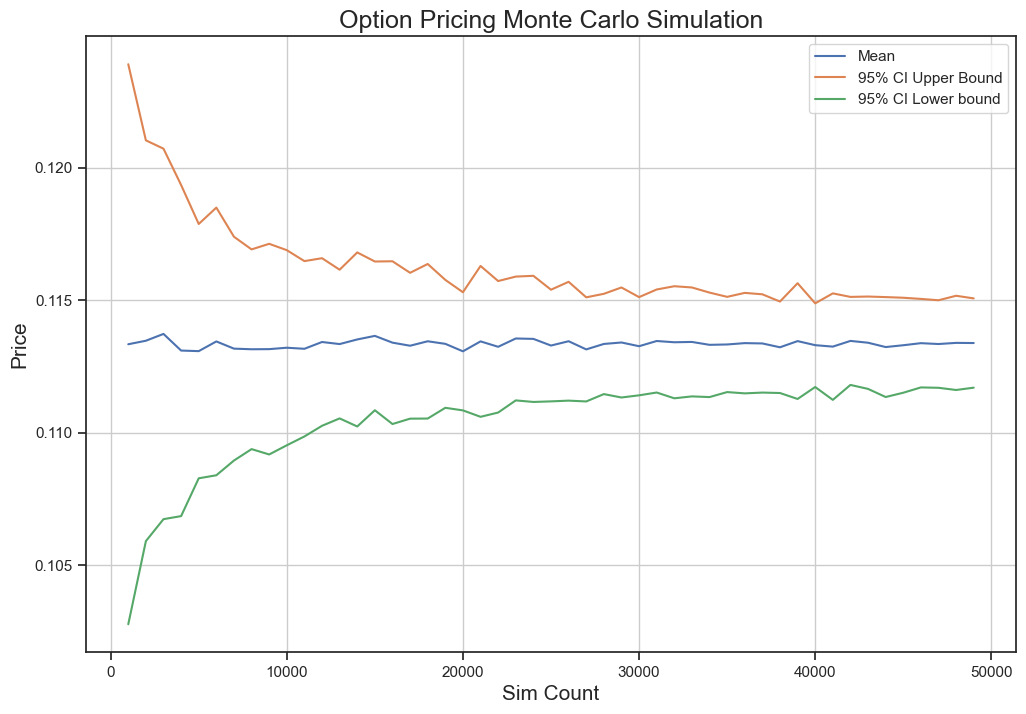

In [62]:
pylab.figure(figsize = (12,8))
tabel = np.array([means,confidenceIntervalUpper,confidenceIntervalLower]).T
pylab.plot(pathScenario, tabel)
pylab.title(u'Option Pricing Monte Carlo Simulation', fontsize = 18)
pylab.legend([u'Mean', u'95% CI Upper Bound', u'95% CI Lower bound'])
pylab.ylabel(u'Price', fontsize = 15)
pylab.xlabel(u'Sim Count', fontsize = 15)
pylab.grid(True)


# 4. Implied Volatility Calculation

### 4.1 use brentq

In [66]:
from scipy.optimize import brentq

In [91]:
# target def, price is determined by target
class cost_function:
    def __init__(self, target):
        self.targetValue = target

    def __call__(self, x):
        return call_option_pricer(spot, strike, maturity, r, x) - self.targetValue

# assume we use Vol initial as target
target = call_option_pricer(spot, strike, maturity, r, vol)
cost_sample = cost_function(target)

# use brentq to get the solution, 0.01, 0.5 is the range for solution
impliedVol = brentq(cost_sample, 0.01, 0.5)

print('Actual Volatility： %.2f' % (vol*100,) + '%')
print('Implied Volatility： %.2f' % (impliedVol*100,) + '%')

Actual Volatility： 25.00%
Implied Volatility： 25.00%


### 4.2 Use Newton-Raphson Method

Newton-Raphson method is used to obtain real roots of linear or non-linear equations. It is also used to solve non-linear simultaneous equations. It’s a fast method but has the following disadvantages:

1. It requires the derivatives of 𝑓(𝑥), if complicated then this method will tend to fail.
2. It requires a very accurate initial value or initial guess 𝑋0. Must be near the root you need to approximate.
3. Function and its derivatives should be continuous on the range you search for root in. If it was not, so the convergence of this method is a dream. (Try to find roots for a function that contains 𝑡𝑎𝑛(𝑥)
)